In [67]:
# Import and preprocess data
import pandas as pd
import numpy as np
import numpy.linalg as la
import pandas as pd
import statsmodels.formula.api as sm
from scipy import stats

dataset = pd.read_csv('/content/drive/MyDrive/Skripsi/all_countries.csv', usecols = ['Country', 'Year', 'HDI', 'IFI','Electuse','Inter', 'Govex_H', 'Unemp', 'Ln_FDI', 'Instquality'],\
index_col = ['Country', 'Year'])

years = dataset.index.get_level_values('Year').to_list()
dataset['Year'] = pd.Categorical(years)

print(dataset.info())
print(dataset.describe())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 130 entries, ('Bangladesh', 2013) to ('Chile', 2017)
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Govex_H      130 non-null    float64 
 1   Electuse     130 non-null    float64 
 2   Unemp        130 non-null    float64 
 3   HDI          130 non-null    float64 
 4   Inter        130 non-null    float64 
 5   Instquality  130 non-null    float64 
 6   IFI          130 non-null    float64 
 7   Ln_FDI       130 non-null    float64 
 8   Year         130 non-null    category
dtypes: category(1), float64(8)
memory usage: 10.5+ KB
None
          Govex_H    Electuse       Unemp  ...  Instquality         IFI      Ln_FDI
count  130.000000  130.000000  130.000000  ...   130.000000  130.000000  130.000000
mean     3.245259   89.477658    7.520769  ...    61.400769    0.457401   21.690599
std      2.199598   17.469207    5.320137  ...     9.857351    0.116806    2.572

In [69]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm
independent_vars = ['IFI', 'Electuse', 'Inter',  'Govex_H', 'Unemp','Ln_FDI', 'Instquality']
exog = sm.tools.tools.add_constant(dataset[independent_vars])
endog = dataset['HDI']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

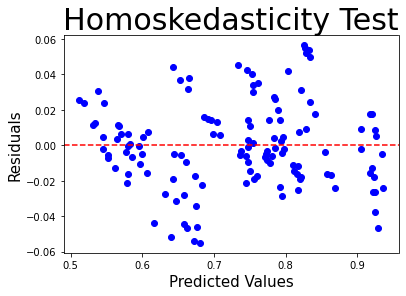

{'LM-Stat': 93.14273412603188, 'LM p-val': 3.535232531010658e-07, 'F-Stat': 6.787122314177216, 'F p-val': 6.294633892163524e-14}
{'LM-Stat': 19.01958501317922, 'LM p-val': 0.008126209754579845, 'F-Stat': 2.98687111580314, 'F p-val': 0.006289616637742131}
durbin_watson_test_results : 
0.60546686935887


In [73]:
# Classical Assumption (Homoskedasticity & Autocorrelation)
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['Year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(dataset[independent_vars]).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual'])
print('durbin_watson_test_results : '  )
print(durbin_watson_test_results)




In [74]:
# FE and RE model
from linearmodels import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels import PooledOLS
import statsmodels.api as sm

independent_vars = ['IFI', 'Electuse', 'Inter',  'Govex_H', 'Unemp','Ln_FDI', 'Instquality']
exog = sm.tools.tools.add_constant(dataset[independent_vars])
endog = dataset['HDI']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
#print results
print(re_res)
print(fe_res)


                        RandomEffects Estimation Summary                        
Dep. Variable:                    HDI   R-squared:                        0.6582
Estimator:              RandomEffects   R-squared (Between):              0.7546
No. Observations:                 130   R-squared (Within):               0.5137
Date:                Thu, Sep 23 2021   R-squared (Overall):              0.7536
Time:                        13:38:38   Log-likelihood                    459.20
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      33.560
Entities:                          26   P-value                           0.0000
Avg Obs:                       5.0000   Distribution:                   F(7,122)
Min Obs:                       5.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             33.560
                            

In [75]:
# Hausman Test
import numpy.linalg as la
from scipy import stats
import numpy as np

def hausman(fe, re):

    # Pull data out
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov

    df = b[np.abs(b) < 1e8].size

    # compute test statistic and associated p-value
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, df)

    return chi2, df, pval
print('# Hausman Test')
hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

# Hausman Test
chi-Squared: -225.52418012881878
degrees of freedom: 8
p-Value: 1.0
